In [47]:
import os
import time
import socket
import struct
import pickle
from tqdm import tqdm
import copy
import sys
import random

import matplotlib.pyplot as plt
import psutil
random.seed(0)

import warnings
warnings.filterwarnings("ignore")

import torch
torch.manual_seed(0)
torch.initial_seed(), 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# Check if CUDA is available, else use CPU
#device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [48]:
EPOCHS = 10
USERS = 1
CUT_LAYER = 1
BOTTLENECK_COMPRESSION = 4
QUANTIZATION_REQUIRED = 1 # 1 for required
QUANTIZATION_TYPE = torch.qint8 # np.uint8, np.int8, np.uint16, np.int16

In [49]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = pickle.dumps(msg)
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)
    return len(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    msg =  recvall(sock, msglen)
    msg = pickle.loads(msg)
    return msg, msglen

def recvall(sock, n):
    # helper function to receive n MB or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

In [50]:
host = 'localhost'
port = 12313

s = socket.socket()
s.bind((host, port))
s.listen(10)

In [51]:
clientsoclist = []
train_total_batch = []
val_acc = []

total_sendsize_list = []
total_receivesize_list = []

client_sendsize_list = [[] for i in range(USERS)]
client_receivesize_list = [[] for i in range(USERS)]

train_sendsize_list = [] 
train_receivesize_list = []

send_time_list = [[] for i in range(USERS)]
recv_time_list = [[] for i in range(USERS)]
total_time_list = [[] for i in range(USERS)]

send_bandwidth_list = [[] for i in range(USERS)]
recv_bandwidth_list = [[] for i in range(USERS)]
total_bandwidth_list = [[] for i in range(USERS)]

loss_list = [[] for i in range(USERS)]

for i in range(USERS):
    conn, addr = s.accept()
    print("conn: ", conn)
    print('Conntected with', addr)
    clientsoclist.append(conn)    # append client socket on list
    msg = {
            'epochs': EPOCHS,
            'users': USERS,
            'cut_layer': CUT_LAYER,
            'bottleneck_compression': BOTTLENECK_COMPRESSION,
            'quantization_required': QUANTIZATION_REQUIRED,
            'QUANTIZATION_TYPE': QUANTIZATION_TYPE
    }
    datasize = send_msg(conn, msg)    #send epoch
    total_sendsize_list.append(sys.getsizeof(msg))
    client_sendsize_list[i].append(sys.getsizeof(msg))

    total_batch, datasize = recv_msg(conn)    # get total_batch of train dataset
    print("Total batch {}", total_batch)
    total_receivesize_list.append(sys.getsizeof(total_batch))
    client_receivesize_list[i].append(sys.getsizeof(total_batch))

    train_total_batch.append(total_batch)    # append on list

conn:  <socket.socket fd=3400, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 12313), raddr=('127.0.0.1', 57960)>
Conntected with ('127.0.0.1', 57960)
Total batch {} 100


In [52]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [53]:
class ClientResNet(nn.Module):
    def __init__(self, block, output_channel=[64,128,256,512], stride=[1,2,2,2], num_blocks=[1,1,1,1], num_classes=10, 
                 bottleneck_compression=4, cut_layer=1):
        super(ClientResNet, self).__init__()
        
        self.in_channels = 64
        self.output_channel = output_channel
        self.stride = stride
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.bottleneck_compression = bottleneck_compression
        self.cut_layer = cut_layer
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layers = []
        for layer in range(0, self.cut_layer):
            self.layers.append(self._make_layer(block, self.output_channel[layer], self.num_blocks[layer], stride=self.stride[layer]))
        self.conv_layers = nn.Sequential(*self.layers)

        if self.bottleneck_compression>=1:
            self.bl_encoder = nn.Conv2d(output_channel[self.cut_layer-1], output_channel[self.cut_layer-1]//bottleneck_compression, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
                
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.conv_layers(out)
        if self.bottleneck_compression>=1:
            out = self.bl_encoder(out)
        return out

# Create the model
client_model = ClientResNet(block=BasicBlock, bottleneck_compression=BOTTLENECK_COMPRESSION, cut_layer=CUT_LAYER)
client_model = client_model.to(device)
print(client_model)
#print(client_model.conv_layers[0][0].conv1.weight)

ClientResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv_layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
    )
  )
  (bl_encoder): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [54]:
class ServerResNet(nn.Module):
    def __init__(self, block, output_channel=[64,128,256,512], stride=[1,2,2,2], num_blocks=[1,1,1,1], num_classes=10, 
                 bottleneck_compression=4, cut_layer=1):
        super(ServerResNet, self).__init__()

        self.output_channel = output_channel
        self.stride = stride
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.bottleneck_compression = bottleneck_compression
        self.cut_layer = cut_layer
        self.in_channels = self.output_channel[self.cut_layer-1]
        

        if self.bottleneck_compression>=1:
            self.bl_decoder = nn.Conv2d(self.output_channel[self.cut_layer-1]//self.bottleneck_compression, self.output_channel[self.cut_layer-1], kernel_size=3, stride=1, padding=1, bias=False)
    
        self.layers = []
        for layer in range(self.cut_layer, 4):
            self.layers.append(self._make_layer(block, self.output_channel[layer], self.num_blocks[layer], stride=self.stride[layer]))
        self.conv_layers = nn.Sequential(*self.layers)
 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, self.num_classes)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.to(device)
        if self.bottleneck_compression>=1:
            x = self.bl_decoder(x)
        out = self.conv_layers(x)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Create the model
server_model = ServerResNet(block=BasicBlock, output_channel=[64,128,256,512], stride=[1,2,2,2], num_blocks=[1,1,1,1], num_classes=10, 
                 bottleneck_compression=BOTTLENECK_COMPRESSION, cut_layer=CUT_LAYER)
server_model = server_model.to(device)
print(server_model)

ServerResNet(
  (bl_decoder): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(2

In [55]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(server_model.parameters(), lr=0.001, momentum=0.9)

In [56]:
def quantize_tensor(tensor, quantization_type):

    min_val, max_val = tensor.min(), tensor.max()

    if quantization_type == torch.quint8:
        scale = torch.tensor((max_val - min_val) / 255)
        zero_point = torch.tensor(max(0, min(255, int(-min_val / scale))))
        return torch.quantize_per_tensor(tensor, scale, zero_point, torch.quint8)

    elif quantization_type == torch.qint8:
        scale = torch.tensor(max_val / 127 if max_val.abs() > min_val.abs() else min_val / -128)
        zero_point = torch.tensor(0)  # For qint8, zero_point is typically set to 0 for symmetric quantization
        return torch.quantize_per_tensor(tensor, scale, zero_point, torch.qint8)

    else:
        raise ValueError("Invalid quantization type. Choose 'quint8' or 'qint8'.")

def dequantize_tensor(quantized_tensor):
    return torch.dequantize(quantized_tensor).requires_grad_(True)

In [57]:
client_weights = copy.deepcopy(client_model.state_dict())

start_time = time.time()    # store start time
print("timer start!")

for e in range(EPOCHS):

    # train client 0
    for user in range(USERS):

        datasize = send_msg(clientsoclist[user], client_weights)
        total_sendsize_list.append(datasize)
        client_sendsize_list[user].append(datasize)
        train_sendsize_list.append(datasize)

        recv_time_total = 0
        send_time_total = 0
        total_time = 0

        for i in tqdm(range(train_total_batch[user]), ncols=100, desc='Epoch {} Client{} '.format(e+1, user)):
            optimizer.zero_grad()  # initialize all gradients to zero

            recv_start_time = time.time()
            msg, datasize = recv_msg(clientsoclist[user])  # receive client message from socket
            recv_end_time = time.time()

            recv_time = recv_end_time - recv_start_time
            recv_time_total += recv_time
            recv_time_avg = recv_time_total/(i+1)

            total_receivesize_list.append(datasize)
            client_receivesize_list[user].append(datasize)
            train_receivesize_list.append(datasize)

            client_output = msg['client_output']  # client output tensor
            label = msg['label']  # label
            label = label.clone().detach().long()
            label = label.to(device)
            
            if QUANTIZATION_REQUIRED == 1:
                client_output = dequantize_tensor(client_output)
            
            output = server_model(client_output).to(device)  # forward propagation
            loss = criterion(output, label)  # calculates cross-entropy loss
            loss.backward()  # backward propagation   
                
            if QUANTIZATION_REQUIRED == 1:
                msg = quantize_tensor(client_output.grad.clone().detach().requires_grad_(True), QUANTIZATION_TYPE)
            
            else:
                msg = client_output.grad.clone().detach().requires_grad_(True)
            
            send_start_time = time.time()
            datasize = send_msg(clientsoclist[user], msg)
            send_end_time = time.time()

            send_time = send_end_time - send_start_time
            send_time_total += send_time
            send_time_avg = send_time_total/(i+1)

            total_sendsize_list.append(datasize)
            client_sendsize_list[user].append(datasize)
            train_sendsize_list.append(datasize)

            total_time += (send_time + recv_time)
            total_time_avg = total_time/(i+1)
            
            optimizer.step()
        
           
        client_weights, datasize = recv_msg(clientsoclist[user])
        total_receivesize_list.append(datasize)
        client_receivesize_list[user].append(datasize)
        train_receivesize_list.append(datasize)
        
        send_time_list[user].append(send_time_avg)
        recv_time_list[user].append(recv_time_avg)
        total_time_list[user].append(total_time_avg)

    print("Loss: ", loss)
    loss_list[user].append(loss.cpu().detach().numpy()) 
        
        
print('train is done')

end_time = time.time()  # store end time
print("TrainingTime: {} sec".format(end_time - start_time))

# Let's quickly save our trained model:
PATH = './server_model_state_dict.pth'
torch.save(server_model.state_dict(), PATH)

timer start!


Epoch 1 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:34<00:00,  2.86it/s]


Loss:  tensor(1.3578, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 2 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


Loss:  tensor(1.1376, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 3 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Loss:  tensor(1.0491, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 4 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


Loss:  tensor(0.9083, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]


Loss:  tensor(0.8714, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.25it/s]


Loss:  tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


Loss:  tensor(0.6476, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]


Loss:  tensor(0.5456, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 Client0 : 100%|███████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


Loss:  tensor(0.5412, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 Client0 : 100%|██████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


Loss:  tensor(0.4351, device='cuda:0', grad_fn=<NllLossBackward0>)
train is done
TrainingTime: 315.1170630455017 sec


Text(0, 0.5, 'Loss')

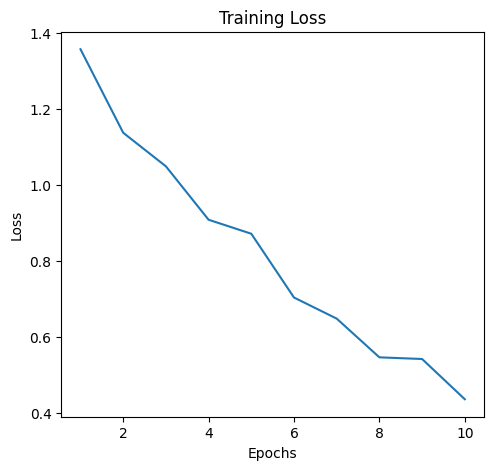

In [63]:
epochs_list = list(range(1, EPOCHS + 1))
#loss_list = loss_list[0]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, loss_list[0])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

client_model.load_state_dict(client_weights)

In [ ]:
with torch.no_grad():
    corr_num = 0
    total_num = 0
    val_loss = 0.0
    for i, val in enumerate(tqdm(trainloader, desc="Training Data")):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label = val_label.to(device)

        val_output = client_model(val_x)
        val_label = val_label.long()
        
        val_output = server_model(val_output)
        
        loss = criterion(val_output, val_label)
        val_loss += loss.item()
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)
    print("train_acc: {:.2f}%, train_loss: {:.4f}".format(corr_num / total_num * 100, val_loss / len(trainloader)))

In [ ]:
with torch.no_grad():
    corr_num = 0
    total_num = 0
    val_loss = 0.0
    for i, val in enumerate(tqdm(testloader, desc="Testing Data")):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label = val_label.to(device)

        val_output = client_model(val_x)
        val_label = val_label.long()
        
        val_output = server_model(val_output)
        
        loss = criterion(val_output, val_label)
        val_loss += loss.item()
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)
    print("test_acc: {:.2f}%, test_loss: {:.4f}".format(corr_num / total_num * 100, val_loss / len(testloader)))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for i, data in enumerate(tqdm(testloader, desc="Testing Data")):
        x, labels = data
        x = x.to(device)
        labels = labels.to(device)

        outputs = client_model(x)
        outputs = server_model(outputs)
        labels = labels.long()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
from thop import profile
x =  torch.randn(50000, 3, 32, 32)
x = x.to(device)
macs, params = profile(client_model, inputs=(x,))
print(macs, params)

In [ ]:
from thop import profile
x =  torch.randn(client_output.shape)
x = x.to(device)
macs, params = profile(server_model, inputs=(x,))
print(macs, params)

In [ ]:
# Replace 'path_to_file' with your file path
file_path = 'server_model_state_dict.pth'

# Get the size of the file in bytes
file_size = os.path.getsize(file_path)

print(f"The size of the file is {file_size / (1024**2)} MB.")

In [ ]:
print(f"Current Memory Usage: {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2} MB")

In [ ]:
client_send_total_size_list = [[] for i in range(USERS)]
client_recv_total_size_list = [[] for i in range(USERS)]

print('---total_sendsize_list---')
totalsend_size = 0
for size in total_sendsize_list:
    totalsend_size += size
print("total_sendsize size: {} MB".format(totalsend_size/(1024**2)))
print("number of total_send: ", len(total_sendsize_list))
print('\n')

print('---total_receivesize_list---')
total_receive_size = 0
for size in total_receivesize_list:
    total_receive_size += size
print("total receive sizes: {} MB".format(total_receive_size/(1024**2)) )
print("number of total receive: ", len(total_receivesize_list) )
print('\n')

for i in range(USERS):
    print('---client_sendsize_list(user{})---'.format(i))
    total_size = 0
    for size in client_sendsize_list[i]:
#         print(size)
        total_size += size
    client_send_total_size_list[i] = total_size
    print("total client_sendsizes(user{}): {} MB".format(i, client_send_total_size_list[i]/(1024**2)))
    print("number of client_send(user{}): ".format(i), len(client_sendsize_list[i]))
    print('\n')

    print('---client_receivesize_list(user{})---'.format(i))
    total_size = 0
    for size in client_receivesize_list[i]:
#         print(size)
        total_size += size
    client_recv_total_size_list[i] = total_size
    print("total client_receive sizes(user{}): {} MB".format(i, client_recv_total_size_list[i]/(1024**2)))
    print("number of client_send(user{}): ".format(i), len(client_receivesize_list[i]))
    print('\n')

print('---train_sendsize_list---')
total_size = 0
for size in train_sendsize_list:
#     print(size)
    total_size += size
train_sendsize = total_size
print("total train_sendsizes: {} MB".format(train_sendsize/(1024**2)))
print("number of train_send: ", len(train_sendsize_list) )
print('\n')

print('---train_receivesize_list---')
total_size = 0
for size in train_receivesize_list:
#     print(size)
    total_size += size
train_recvsize = total_size
print("total train_receivesizes: {} MB".format(train_recvsize/(1024**2)))
print("number of train_receive: ", len(train_receivesize_list) )
print('\n')

In [ ]:
for i in range(USERS):
    print('client_send_time(user{}) - {} seconds'.format(i, send_time_list[i]))

for i in range(USERS):
    print('client_receive_time(user{}) - {} seconds'.format(i, recv_time_list[i]))

for i in range(USERS):
    print('client_total_time(user{}) - {} seconds'.format(i, total_time_list[i]))

In [ ]:
for i in range(USERS):
    print('client_send_bandwidth(user{}) - {} MB/sec'.format(i, (client_send_total_size_list[i]/send_time_list[i][0])/(1024**2)))

for i in range(USERS):
    print('client_receive_bandwidth(user{}) - {} MB/sec'.format(i, (client_recv_total_size_list[i]/recv_time_list[i][0])/(1024**2)))